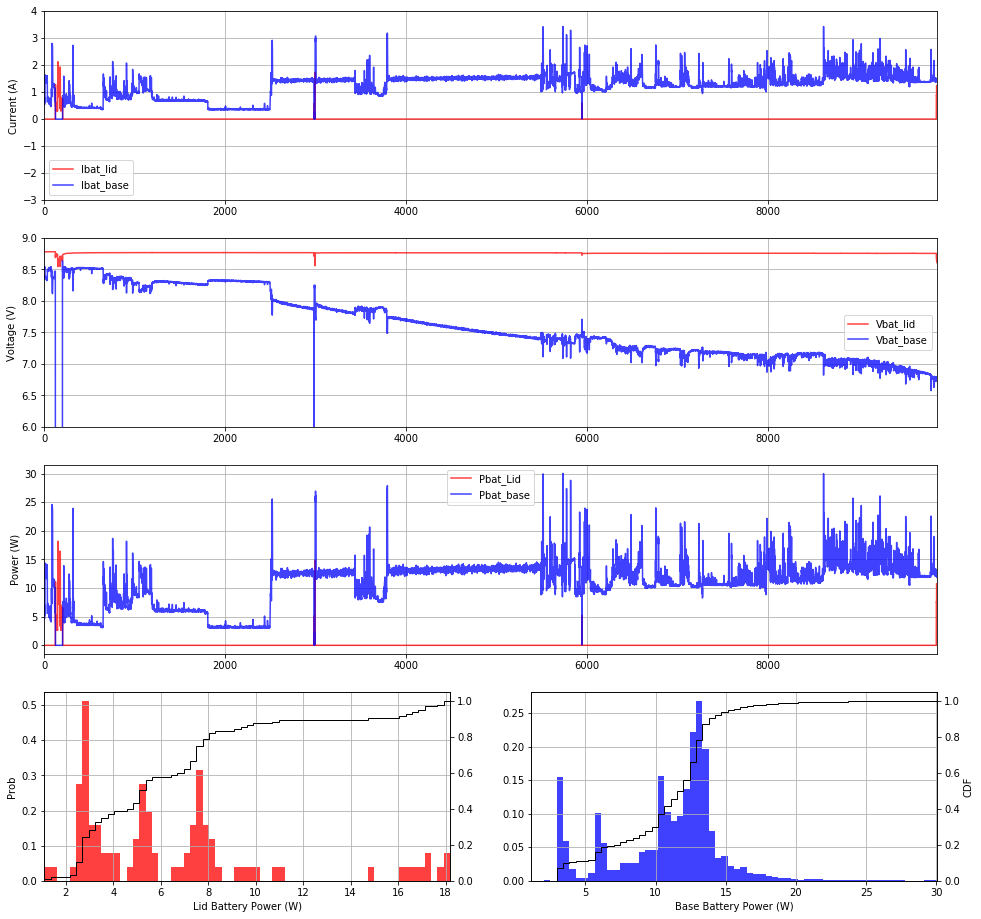

In [40]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

df = pd.read_csv('/tmp/mon.csv')

plt.figure(figsize=(16,20),facecolor='white')
gs = gridspec.GridSpec(4, 2)
ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, :])
ax2 = plt.subplot(gs[2, :])
ax3 = plt.subplot(gs[3, 0])
ax4 = plt.subplot(gs[3, 1])

ax0.plot(df["i0"]/1e6, 'r', label='Ibat_lid', alpha=0.75)
ax0.plot(df["i1"]/1e6, 'b', label='Ibat_base', alpha=0.75)
ax0.set_ylim([-3,4])
ax0.set_xlim([0,len(df["i0"])])
ax0.grid(True)
ax0.legend()

ax1.plot(df["v0"]/1e6, 'r', label='Vbat_lid', alpha=0.75)
ax1.plot(df["v1"]/1e6, 'b', label='Vbat_base', alpha=0.75)
ax1.set_ylim([6,9])
ax1.set_xlim([0,len(df["i0"])])
ax1.grid(True)
ax1.legend()

ax2.plot(df["i0"]*df["v0"]/1e12, 'r', label='Pbat_Lid', alpha=0.75)
ax2.plot(df["i1"]*df["v0"]/1e12, 'b', label='Pbat_base', alpha=0.75)
ax2.set_xlim([0,len(df["i0"])])
ax2.grid(True)
ax2.legend()

ax0.set_ylabel('Current (A)')
ax1.set_ylabel('Voltage (V)')
ax2.set_ylabel('Power (W)');

p0 = df["i0"]*df["v0"]/1e12
p1 = df["i1"]*df["v0"]/1e12

p0 = p0[p0>1]
p1 = p1[p1>1]

num_bins = 64

ax3_1 = ax3.twinx()
ax4_1 = ax4.twinx()

ax3.grid(True)
ax4.grid(True)

# the histogram of the data
n, bins, patches = ax3.hist(p0, num_bins, normed=1, facecolor='red', alpha=0.75)

ax3_1.hist(p0, bins=bins, normed=1, histtype='step', color='black', cumulative=True, label='CDF')


n, bins, patches = ax4.hist(p1, num_bins, normed=1, facecolor='blue', alpha=0.75)

ax4_1.hist(p1, bins=bins, normed=1, histtype='step', color='black', cumulative=True, label='CDF')

ax3.set_ylabel('Prob')
ax4_1.set_ylabel('CDF')

ax3.set_xlabel('Lid Battery Power (W)')
ax4.set_xlabel('Base Battery Power (W)')
ax3.set_xlim([min(p0),max(p0)])
ax4.set_xlim([min(p1),max(p1)]);

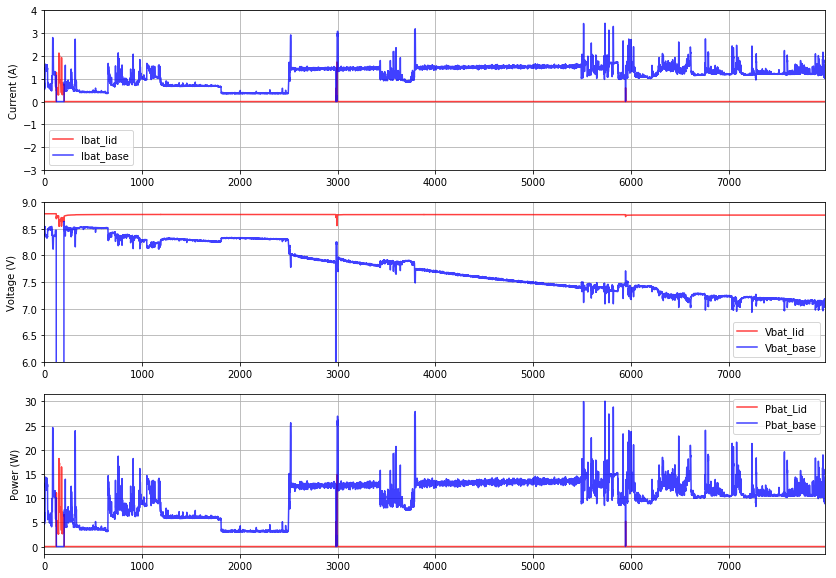

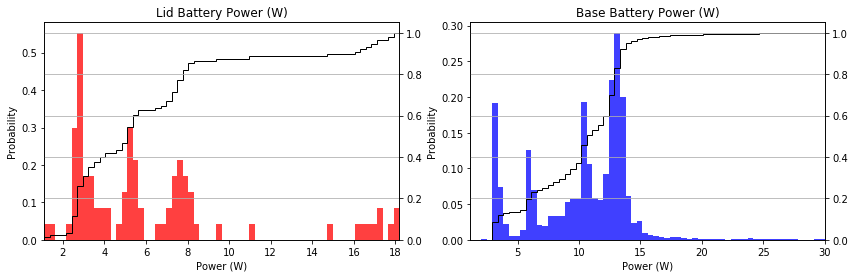

In [24]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/tmp/mon.csv')

fig,ax=plt.subplots(3,1, figsize=(14,10), facecolor='white')
ax[0].grid(True)
ax[1].grid(True)

ax[0].plot(df["i0"]/1e6, 'r', label='Ibat_lid', alpha=0.75)
ax[0].plot(df["i1"]/1e6, 'b', label='Ibat_base', alpha=0.75)
ax[0].set_ylim([-3,4])
ax[0].set_xlim([0,len(df["i0"])])
ax[0].legend()

ax[1].plot(df["v0"]/1e6, 'r', label='Vbat_lid', alpha=0.75)
ax[1].plot(df["v1"]/1e6, 'b', label='Vbat_base', alpha=0.75)
ax[1].set_ylim([6,9])
ax[1].set_xlim([0,len(df["i0"])])
ax[1].legend()

ax[2].plot(df["i0"]*df["v0"]/1e12, 'r', label='Pbat_Lid', alpha=0.75)
ax[2].plot(df["i1"]*df["v0"]/1e12, 'b', label='Pbat_base', alpha=0.75)
ax[2].set_xlim([0,len(df["i0"])])
ax[2].grid(True)
ax[2].legend()

ax[0].set_ylabel('Current (A)')
ax[1].set_ylabel('Voltage (V)')
ax[2].set_ylabel('Power (W)');

p0 = df["i0"]*df["v0"]/1e12
p1 = df["i1"]*df["v0"]/1e12

p0 = p0[p0>1]
p1 = p1[p1>1]

num_bins = 30

fig,ax=plt.subplots(1,2, figsize=(14,4))
ax0 = ax[0].twinx()
ax1 = ax[1].twinx()

ax0.grid(True)
ax1.grid(True)

# the histogram of the data
n, bins, patches = ax[0].hist(p0, num_bins, normed=1, facecolor='red', alpha=0.75)

ax0.hist(p0, bins=bins, normed=1, histtype='step', cumulative=True, label='CDF')


n, bins, patches = ax[1].hist(p1, num_bins, normed=1, facecolor='blue', alpha=0.75)

ax1.hist(p1, bins=bins, normed=1, histtype='step', color='black', cumulative=True, label='CDF')


for ax_ in ax:
    ax_.set_xlabel('Power (W)')
    ax_.set_ylabel('Probability')

ax[0].set_title('Lid Battery Power (W)')
ax[1].set_title('Base Battery Power (W)')
ax[0].set_xlim([min(p0),max(p0)])
ax[1].set_xlim([min(p1),max(p1)]);

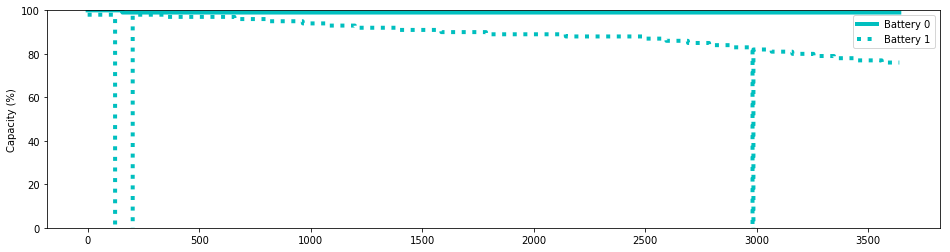

In [15]:
fig,ax=plt.subplots(figsize=(16,4))
ax.plot(df["c0"], 'c', lw=4, label='Battery 0')
ax.plot(df["c1"], 'c:', lw=4, label='Battery 1')
ax.set_ylim([0,100])
ax.set_ylabel('Capacity (%)');
ax.legend()